In [1]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
import os

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-v0_8-poster')
import numpy as np
import pandas as pd
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import open2c libraries
import bioframe

import cooler
import cooltools
import cooltools.lib.plotting
import cooltools.lib.numutils

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorial relies on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load a Hi-C map from a cooler file.
resolution = 1000 # kb
clr = cooler.Cooler(f'/Users/douglas/Documents/Features_Transfer/store_Hi-C/JJ10_11_17_18.wo3kbCisTransHom.{resolution}.cool')

# Coarse Grain Pearson PCA

In [3]:
# Select the first chromosome
max_entry = 22950
matrix = clr.matrix(balance=False)[0:max_entry,0:max_entry] # most of maternal chromosome 2
matrix = np.nan_to_num(matrix) # make the nan entries 0

In [4]:
# Coarse grain the matrix to speed up computations.
res = 150 # resolution at which to coarse grain in kb
c_m_n = int(max_entry/res) # coarse_matrix number columns and rows (should be an integer)
print(c_m_n)
coarse_matrix = np.zeros((c_m_n,c_m_n))
for i in range(c_m_n):
    for j in range(c_m_n):
        coarse_matrix[i,j] = np.sum(matrix[i*res:(i+1)*res,j*res:(j+1)*res])

153


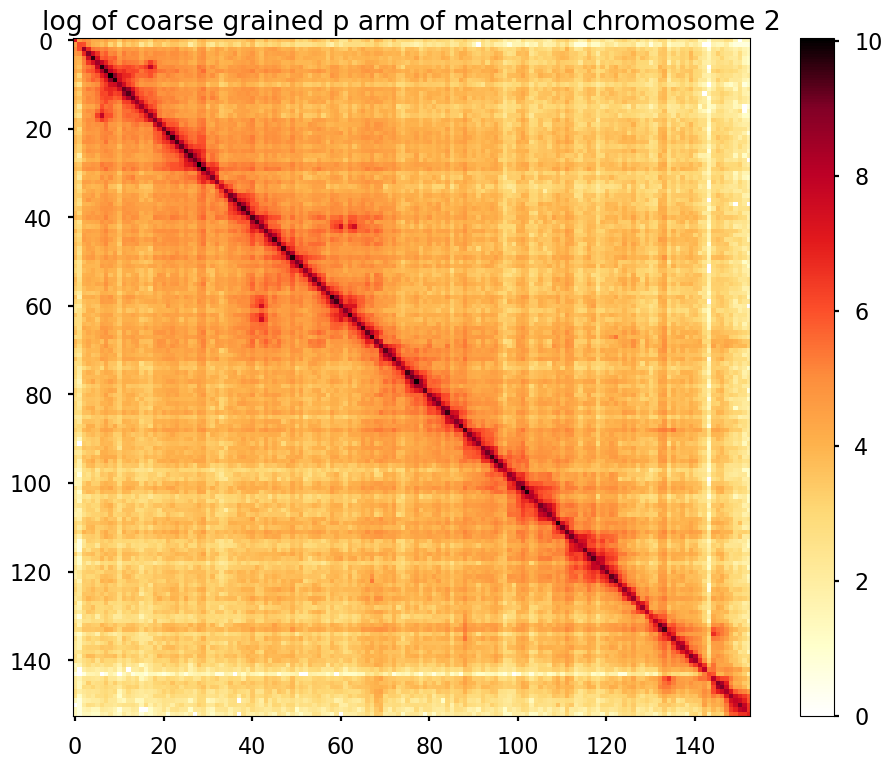

In [5]:
plt.title('log of coarse grained p arm of maternal chromosome 2')
plt.imshow(np.log(coarse_matrix),cmap='fall')
plt.colorbar()
plt.show()

In [ ]:
# Compute matrix's average value at genomic distances
N = coarse_matrix.shape[0]
average = np.zeros((N,N))
for d in range(N):
    sum_d = 0.0
    for i in range(d,N):
        sum_d += coarse_matrix[i][i-d]
    avg = sum_d/(N-d)
    for i in range(d,N):
        average[i][i-d] = avg
        average[i-d][i] = avg

plt.imshow(np.log(average),cmap='fall')
plt.title('log of Average')
plt.colorbar()
plt.show()

In [ ]:
coarse_matrix_divided_diagonal = coarse_matrix/average

plt.title('log of O/E')
plt.imshow(np.log(coarse_matrix_divided_diagonal),cmap='fall')
plt.colorbar()
plt.show()

In [ ]:
pearson_matrix = np.corrcoef(coarse_matrix_divided_diagonal)
plt.title('Pearson of O/E')
plt.imshow(pearson_matrix,cmap='fall')
plt.colorbar()
plt.show()

In [ ]:
U, D, VT = np.linalg.svd(pearson_matrix)
sigma1 =D[0]
firstPrincipalComponent = sigma1*U[:,0]#first column of U is proportional to the first eigenvector in the original basis.
plt.title('First Principal Component of Pearson Matrix of chr2')
plt.plot(firstPrincipalComponent)

In [ ]:
ABthreshold = -5.9

types_chr_2_mat = []
A_counter_exp = 0 # total number of bins of type A
B_counter_exp = 0 # total number of bins of type B
for i in range(len(firstPrincipalComponent)):
    if firstPrincipalComponent[i] >= ABthreshold:
        for j in range(res):
            types_chr_2_mat.append('A1')
            A_counter_exp += 1
    else:
        for j in range(res):
            types_chr_2_mat.append('B1')
            B_counter_exp += 1
        
types_array = np.array(types_chr_2_mat,dtype=str)

percent_A_exp = round(100*A_counter_exp/(A_counter_exp+B_counter_exp),1)
percent_B_exp = round(100*B_counter_exp/(A_counter_exp+B_counter_exp),1)
print('Experiment')
print(f'A: {percent_A_exp}%  B: {percent_B_exp}%')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,20),nrows=3, ncols=1, 
                               sharex = True,
                               height_ratios=[4, 1, 60])

ax1.plot(firstPrincipalComponent)
ax1.set_ylabel('Eigenvector')

heatmap, xedges, yedges = np.histogram2d(range(c_m_n),firstPrincipalComponent, bins=(np.linspace(0,c_m_n,c_m_n+1),1))
extent = [0, c_m_n+1, 0, 20]
ABtypes = np.heaviside(firstPrincipalComponent-ABthreshold,1)
ax2.imshow(ABtypes[np.newaxis,:], cmap="bwr", aspect="auto", extent=extent)
ax2.set_ylabel('Types')
ax2.tick_params(bottom = False,left=False) 
ax2.set_yticks([])

ax3.imshow(pearson_matrix, cmap='fall') # aspect='auto' prevents weird spacing
ax3.set_xlabel('Position along chromosome (bin width = 150kb)')
ax3.set_ylabel('chr2 maternal 0-23Mb')

plt.tight_layout() # makes the plots closer
plt.show()

In [ ]:
N = matrix.shape[0]

# compute P vs d
P_exp_chr2 = np.zeros(N)
for d in range(N):
    sum_d = 0.0
    counter = 0.0
    for i in range(d,N):
        if True:
            sum_d += matrix[i][i-d]
            counter += 1.0
        if counter != 0:
            avg = sum_d/counter
            P_exp_chr2[d] = avg

In [ ]:
N = matrix.shape[0]

# compute P_AB vs d
PAB_exp_chr2 = np.zeros(N)
for d in range(N):
    sum_d = 0.0
    counter = 0.0
    for i in range(d,N):
        if (types_array[i]=="A1" and types_array[i-d]=="B1") or (types_array[i]=="B1" and types_array[i-d]=="A1"):
            sum_d += matrix[i][i-d]
            counter += 1.0
        if counter != 0:
            avg = sum_d/counter
            PAB_exp_chr2[d] = avg
          

In [ ]:
  
# compute P_AA vs d
PAA_exp_chr2 = np.zeros(N)
for d in range(N):
    sum_d = 0.0
    counter = 0.0
    for i in range(d,N):
        if types_array[i]=="A1" and types_array[i-d]=="A1":
            sum_d += matrix[i][i-d]
            counter += 1.0
        if counter != 0:
            avg = sum_d/counter
            PAA_exp_chr2[d] = avg

In [ ]:
# compute P_AB vs d
PBB_exp_chr2 = np.zeros(N)
for d in range(N):
    sum_d = 0.0
    counter = 0.0
    for i in range(d,N):
        if types_array[i]=="B1" and types_array[i-d]=="B1":
            sum_d += matrix[i][i-d]
            counter += 1.0
        if counter != 0:
            avg = sum_d/counter
            PBB_exp_chr2[d] = avg
            

In [ ]:
plt.plot(d_exp, P_exp_chr2, label='P_exp',color='black')
plt.plot(d_exp,PAA_exp_chr2, label='PAA_exp',color='red')
plt.plot(d_exp, PAB_exp_chr2, label='PAB_exp',color='purple')
plt.plot(d_exp,PBB_exp_chr2, label='PBB_exp',color='blue')

plt.title('Experiment')
plt.xlabel('genomic distance (kb)')
plt.xlim(4000,1000000)
plt.xscale('log')
plt.ylabel('contact frequency')
plt.ylim(3e-3,3)
plt.yscale('log')
plt.legend()
plt.show()

# PAA_sim, PAB_sim, and PBB_sim vs d simulation

In [ ]:
# For the simulations used to measure PAA vs d,
# calculate the percentage of simulation beads that are A and B.
seq_path = '/Users/douglas/Documents/DiPierroLab_Douglas/1_make_sequences/'
A_counter_sim = 0 # total number of bins of type A
B_counter_sim = 0 # total number of bins of type B

for i in range(1,11):
    seq = np.loadtxt(seq_path+f'chr_ABAB_random_offset_{i}_2500_beads.txt',str)   
    for j in range(len(seq)):
        if seq[j,1] == 'A1':
            A_counter_sim += 1
        elif seq[j,1] == 'B1':
            B_counter_sim += 1

percent_A_sim = round(100*A_counter_sim/(A_counter_sim+B_counter_sim),1)
percent_B_sim = round(100*B_counter_sim/(A_counter_sim+B_counter_sim),1)
print('Simulation')
print(f'A: {percent_A_sim}%  B: {percent_B_sim}%')

In [ ]:
sim_P_vs_d_path = '/Users/douglas/Documents/Features_Transfer/store_Ps_vs_genomic_graphs/'

# Average over many similuations with random chromatin types.
P_sims = [np.loadtxt(sim_P_vs_d_path+f'PvsGenomic_directory_{i}.txt') for i in range(379,389)]
PAA_sims = [np.loadtxt(sim_P_vs_d_path+f'PAAvsGenomic_directory_{i}.txt') for i in range(379,389)]
PAB_sims = [np.loadtxt(sim_P_vs_d_path+f'PABvsGenomic_directory_{i}.txt') for i in range(379,389)]
PBB_sims = [np.loadtxt(sim_P_vs_d_path+f'PBBvsGenomic_directory_{i}.txt') for i in range(379,389)]

P_sim = np.zeros(2500)#average A-to-A contact probablility over the set of simulations
for P_sim in P_sims:
    P_sim += P_sim/10

PAA_sim = np.zeros(2500)#average A-to-A contact probablility over the set of simulations
for PAA_sim in PAA_sims:
    PAA_sim += PAA_sim/10

PAB_sim = np.zeros(2500)#average A-to-A contact probablility over the set of simulations
for PAB_sim in PAB_sims:
    PAB_sim += PAB_sim/10

PBB_sim = np.zeros(2500)#average A-to-A contact probablility over the set of simulations
for PBB_sim in PBB_sims:
    PBB_sim += PBB_sim/10
    
# rebin the 500bp res P vs d graphs at 1kb resolution
d = np.array(range(2500))*500

In [ ]:
plt.plot(d,P_sim,label='P_sim',color='black',linestyle='dashed')
plt.plot(d,PAA_sim,label='PAA_sim',color='red',linestyle='dashed')
plt.plot(d,PAB_sim,label='PAB_sim',color='purple',linestyle='dashed')
plt.plot(d,PBB_sim,label='PBB_sim',color='blue',linestyle='dashed')

plt.title('Simulation')
plt.xlabel('genomic distance (kb)')
plt.xlim(4000,1000000)
plt.xscale('log')
plt.ylabel('contact probability')
plt.ylim(1e-4,3)
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
def rebin(array_like, old_bins_per_new_bin):
    N = len(array_like)
    rebinned_list = []
    for i in range(round(N/old_bins_per_new_bin)):
        new_element = 0
        for j in range(old_bins_per_new_bin):
            new_element += array_like[old_bins_per_new_bin*i+j]
        new_element /= old_bins_per_new_bin # Sets the first bin's probability to 1
        rebinned_list.append(new_element)
    rebinned_array = np.array(rebinned_list)
    return rebinned_array

# Rebin and Rescale

In [ ]:
# Rebin (Don't run more than once or the plots won't work!)
P_sim = rebin(P_sim,2)
PAA_sim = rebin(PAA_sim,2)
PAB_sim = rebin(PAB_sim,2)
PBB_sim = rebin(PBB_sim,2)

In [ ]:
# Rescale
pos = 5 # bin at which to equate cis experiment and cis simulation

rescale_factor = P_exp_chr2[pos]/P_sim[pos]
print(P_exp_chr2[pos])
print(P_sim[pos])

P_sim *= rescale_factor
PAA_sim *= rescale_factor
PAB_sim *= rescale_factor
PBB_sim *= rescale_factor

print('')
print(P_exp_chr2[pos])
print(P_sim[pos])

# Combine them into one plot!

In [ ]:
d = np.array(range(1250))
d_exp = np.array(range(max_entry))

In [ ]:
plt.plot(d_exp, P_exp_chr2, label='P_exp',color='black')
plt.plot(d_exp,PAA_exp_chr2, label='PAA_exp',color='red')
plt.plot(d_exp, PAB_exp_chr2, label='PAB_exp',color='purple')
plt.plot(d_exp,PBB_exp_chr2, label='PBB_exp',color='blue')

plt.plot(d,P_sim,label='P_sim',color='black',linestyle='dashed')
plt.plot(d,PAA_sim,label='PAA_sim',color='red',linestyle='dashed')
plt.plot(d,PAB_sim,label='PAB_sim',color='purple',linestyle='dashed')
plt.plot(d,PBB_sim,label='PBB_sim',color='blue',linestyle='dashed')

plt.title('Compare Experiment and Simulation')
plt.xlabel('genomic distance (kb)')
plt.xlim(4,1000)
plt.xscale('log')
plt.ylabel('contact frequency')
plt.ylim(1e-4,3)
plt.yscale('log')
plt.legend()
plt.show()